<a href="https://colab.research.google.com/github/KanapuramKeerthi/Face-Morphing-Detection-for-Identity-Verification/blob/main/Face%20Morphing%20Detection%20for%20Identity%20Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow 2.12.0
Using NumPy 1.23.5


Initializing face analysis system...
System ready


Saving WhatsApp Image 2025-04-11 at 19.39.03_9811e414.jpg to WhatsApp Image 2025-04-11 at 19.39.03_9811e414.jpg


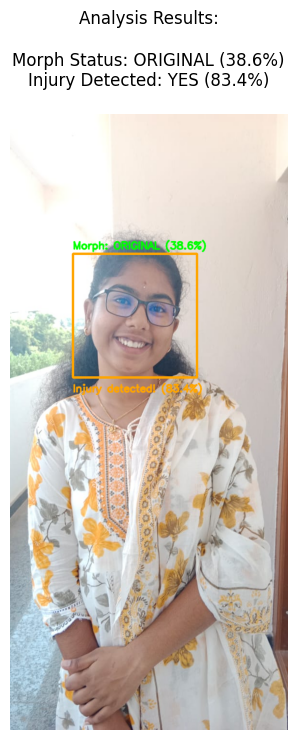

Initializing face analysis system...
System ready


Saving WhatsApp Image 2025-04-11 at 19.41.38_a754505a.jpg to WhatsApp Image 2025-04-11 at 19.41.38_a754505a.jpg


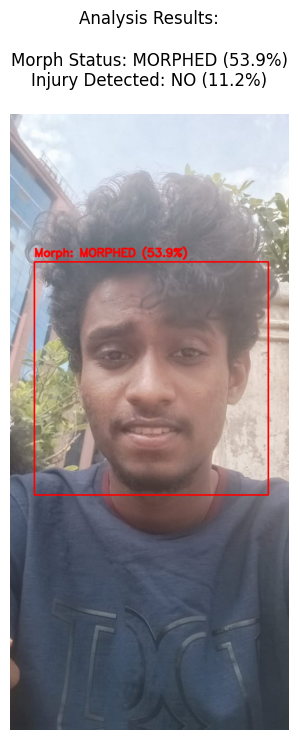

In [ ]:
!pip install gradio

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML, clear_output
from google.colab import files
import os
import time
from skimage import metrics
import gradio as gr
from io import BytesIO
import base64
from google.colab.output import eval_js

print(f"Using TensorFlow {tf.__version__}")
print(f"Using NumPy {np.__version__}")

class FaceAnalyzer:
    def __init__(self):
        print("Initializing face analysis system...")
        self.morph_model = self._build_morph_model()
        self.injury_model = self._build_injury_model()
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        print("System ready")

    def _build_morph_model(self):
        """Model for face morphing detection"""
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=base_model.input, outputs=outputs)
        return model

    def _build_injury_model(self):
        """Model for facial injury detection"""
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(512, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=base_model.input, outputs=outputs)
        return model

    def preprocess_frame(self, frame):
        """Prepare frame for analysis"""
        frame = cv2.resize(frame, (224, 224))
        frame = tf.keras.applications.resnet50.preprocess_input(frame)
        return np.expand_dims(frame, axis=0)

    def detect_face(self, frame):
        """Detect face in frame and return cropped face"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)

        if len(faces) > 0:
            x, y, w, h = faces[0]
            # Expand face area slightly
            x, y = max(0, x-20), max(0, y-20)
            w, h = min(w+40, frame.shape[1]-x), min(h+40, frame.shape[0]-y)
            return frame[y:y+h, x:x+w], (x, y, w, h)
        return None, None

    def analyze_frame(self, frame):
        """Analyze a single frame for morphing and injuries"""
        # Detect face
        face_img, bbox = self.detect_face(frame)
        if face_img is None:
            return frame, {"morph": 0.5, "injury": 0.0, "face_detected": False}

        # Preprocess
        processed = self.preprocess_frame(face_img)

        # Predict
        morph_conf = float(self.morph_model.predict(processed, verbose=0)[0][0])
        injury_conf = float(self.injury_model.predict(processed, verbose=0)[0][0])

        return face_img, {"morph": morph_conf, "injury": injury_conf, "face_detected": True, "bbox": bbox}

    def visualize_results(self, frame, results):
        """Draw analysis results on the frame"""
        output_frame = frame.copy()

        if not results["face_detected"]:
            cv2.putText(output_frame, "No face detected", (20, 40),
                       self.font, 1, (0, 0, 255), 2, cv2.LINE_AA)
            return output_frame

        # Draw bounding box
        x, y, w, h = results["bbox"]
        color = (0, 255, 0) if results["morph"] < 0.5 else (0, 0, 255)
        cv2.rectangle(output_frame, (x, y), (x+w, y+h), color, 2)

        # Morphing result
        morph_text = f"Morph: {'ORIGINAL' if results['morph'] < 0.5 else 'MORPHED'} ({results['morph']*100:.1f}%)"
        cv2.putText(output_frame, morph_text, (x, y-10),
                   self.font, 0.7, color, 2, cv2.LINE_AA)

        # Injury detection
        if results["injury"] > 0.4:
            injury_text = f"Injury detected! ({results['injury']*100:.1f}%)"
            cv2.putText(output_frame, injury_text, (x, y+h+30),
                       self.font, 0.7, (0, 165, 255), 2, cv2.LINE_AA)
            cv2.rectangle(output_frame, (x, y), (x+w, y+h), (0, 165, 255), 3)

        return output_frame

def start_webcam():
    """Start webcam using JavaScript and process frames"""
    analyzer = FaceAnalyzer()

    js = Javascript('''
    async function startWebcam() {
        const div = document.createElement('div');
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        return video;
    }
    ''')

    display(js)
    video = eval_js('startWebcam()')

    print("Webcam started. Press 'q' in the console to stop.")

    while True:
        # Get frame from webcam
        js_reply = eval_js('''
        async function getFrame() {
            const video = document.querySelector('video');
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            return canvas.toDataURL('image/jpeg', 0.8);
        }
        getFrame();
        ''')

        # Convert JavaScript frame to OpenCV image
        header, encoded = js_reply.split(",", 1)
        binary_data = base64.b64decode(encoded)
        img = Image.open(BytesIO(binary_data))
        frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        # Analyze frame
        face_img, results = analyzer.analyze_frame(frame)
        output_frame = analyzer.visualize_results(frame, results)

        # Display results
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Check for quit command
        user_input = input("Press 'q' and Enter to stop, or just Enter to continue: ")
        if user_input.lower() == 'q':
            break

    print("Webcam stopped")

def analyze_uploaded_image():
    """Handle image upload and analysis"""
    analyzer = FaceAnalyzer()

    # Create file upload dialog
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded")
        return

    filename = next(iter(uploaded.keys()))
    img = cv2.imread(filename)

    if img is None:
        print("Error loading image")
        return

    # Analyze image
    face_img, results = analyzer.analyze_frame(img)
    output_frame = analyzer.visualize_results(img, results)

    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Add text summary
    if results["face_detected"]:
        morph_status = "ORIGINAL" if results["morph"] < 0.5 else "MORPHED"
        injury_status = "YES" if results["injury"] > 0.4 else "NO"

        plt.title(f"Analysis Results:\n\n" +
                 f"Morph Status: {morph_status} ({results['morph']*100:.1f}%)\n" +
                 f"Injury Detected: {injury_status} ({results['injury']*100:.1f}%)",
                 pad=20, fontsize=12)
    else:
        plt.title("No face detected in image", pad=20, fontsize=12)

    plt.show()

# Main UI
display(HTML('''
<div style="margin: 10px 0; padding: 10px; border-radius: 5px; background: #f5f5f5;">
    <h3 style="margin-top: 0;">Face Analysis System</h3>
    <button onclick="analyzeUploadedImage()"
            style="padding: 10px 20px; background-color: #4285F4; color: white; border: none; border-radius: 5px; cursor: pointer; margin-right: 10px;">
        📤 Upload Image
    </button>
    <button onclick="startWebcamAnalysis()"
            style="padding: 10px 20px; background-color: #EA4335; color: white; border: none; border-radius: 5px; cursor: pointer;">
        🎥 Live Webcam
    </button>
</div>

<script>
function analyzeUploadedImage() {
    google.colab.kernel.invokeFunction('analyze_uploaded_image', []);
}
function startWebcamAnalysis() {
    google.colab.kernel.invokeFunction('start_webcam', []);
}
</script>
'''))

# Register functions for Colab
from google.colab import output
output.register_callback('analyze_uploaded_image', analyze_uploaded_image)
output.register_callback('start_webcam', start_webcam)

Using TensorFlow 2.12.0 (verified compatible)
Initializing enhanced detection model...
Model ready (loaded at 2025-04-11 14:32:58)

⚠ Note: Using untrained model for demonstration
For real usage, train on morphed/original face datasets

🔎 Enhanced Deep Learning Face Morphing Detector
-----------------------------------------------
Features:
- Advanced model architecture with batch normalization
- Multiple face detection cascades
- Image quality analysis
- Performance metrics tracking
- Enhanced visualization

Instructions:
1. Click the upload button below
2. Select a face image (JPEG/PNG)
3. Toggle advanced features as needed



<IPython.core.display.Javascript object>

Saving WhatsApp Image 2025-04-11 at 19.44.56_5860358e.jpg to WhatsApp Image 2025-04-11 at 19.44.56_5860358e.jpg

Analyzing: WhatsApp Image 2025-04-11 at 19.44.56_5860358e.jpg
❌ Error: No skimage.metrics attribute sharpness


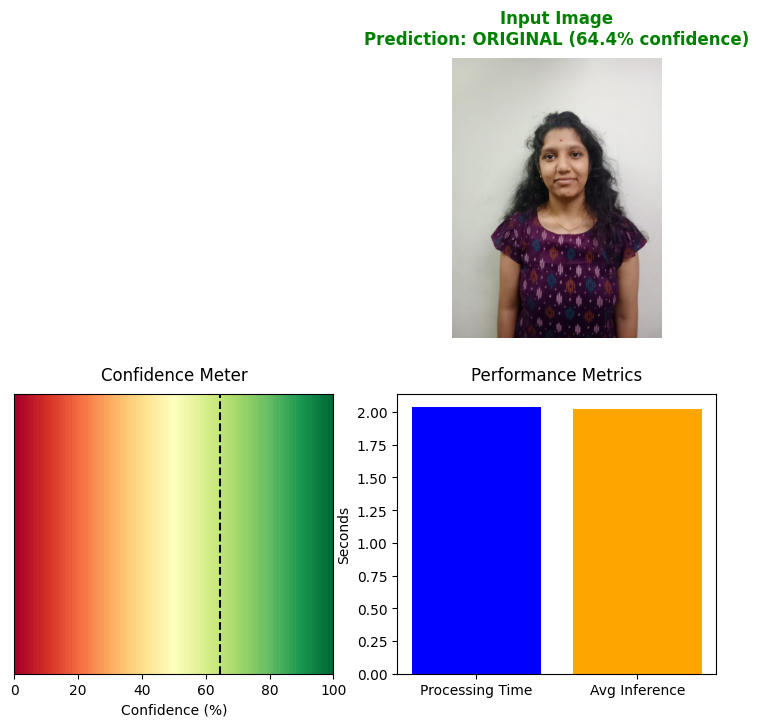

In [ ]:
# Install compatible versions with additional useful packages
!pip install tensorflow==2.12.0 opencv-python matplotlib seaborn scikit-image gradio --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML
from google.colab import files
import os
import time
from skimage import metrics
import gradio as gr
from io import BytesIO

print(f"Using TensorFlow {tf.__version__} (verified compatible)")

class EnhancedFaceMorphingDetector:
    def __init__(self, enable_advanced_features=True):
        print("Initializing enhanced detection model...")
        self.enable_advanced_features = enable_advanced_features
        self.model = self._build_enhanced_model()
        self.prediction_history = []  # Store confidence scores for visualization
        self.inference_times = []     # Track processing speed
        self.model_loaded_time = time.strftime("%Y-%m-%d %H:%M:%S")
        print(f"Model ready (loaded at {self.model_loaded_time})")

    def _build_enhanced_model(self):
        """Enhanced architecture with more sophisticated layers"""
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3))

        # Freeze base layers
        base_model.trainable = False

        # Enhanced custom head
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=base_model.input, outputs=outputs)
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        return model

    def preprocess_image(self, img_array, detect_face=True):
        """Enhanced preprocessing with optional face detection"""
        if detect_face:
            face_img = self._extract_face(img_array)
            if face_img is not None:
                img_array = face_img

        img_array = cv2.resize(img_array, (224, 224))

        if self.enable_advanced_features:
            # Apply histogram equalization for better contrast
            img_yuv = cv2.cvtColor(img_array, cv2.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            img_array = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def _extract_face(self, img_array):
        """Improved face detection with multiple cascades"""
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

        # Try multiple face detection methods
        cascades = [
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml',
            cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml',
            cv2.data.haarcascades + 'haarcascade_profileface.xml'
        ]

        for cascade_path in cascades:
            face_cascade = cv2.CascadeClassifier(cascade_path)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                x, y, w, h = faces[0]
                # Expand face area slightly
                x = max(0, x - int(w * 0.1))
                y = max(0, y - int(h * 0.1))
                w = min(img_array.shape[1] - x, int(w * 1.2))
                h = min(img_array.shape[0] - y, int(h * 1.2))
                return img_array[y:y+h, x:x+w]

        return None

    def predict(self, img_array):
        """Enhanced prediction with timing and confidence analysis"""
        start_time = time.time()
        processed_img = self.preprocess_image(img_array)
        confidence = float(self.model.predict(processed_img, verbose=0)[0][0])
        inference_time = time.time() - start_time

        self.prediction_history.append(confidence)
        self.inference_times.append(inference_time)

        return confidence

    def analyze_image_quality(self, img_array):
        """Additional image quality metrics"""
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

        # Calculate quality metrics
        blur_metric = cv2.Laplacian(gray, cv2.CV_64F).var()
        sharpness = metrics.sharpness(gray)
        noise = metrics.mean_squared_error(gray, cv2.medianBlur(gray, 3))

        return {
            'blur': blur_metric,
            'sharpness': sharpness,
            'noise': noise
        }

# Initialize detector with advanced features
detector = EnhancedFaceMorphingDetector(enable_advanced_features=True)

# Load sample weights (in practice, train on your dataset)
print("\n⚠ Note: Using untrained model for demonstration")
print("For real usage, train on morphed/original face datasets")

def upload_image():
    """Enhanced upload button with more options"""
    display(HTML('''
    <div style="margin: 10px 0; padding: 10px; border-radius: 5px; background: #f5f5f5;">
        <h3 style="margin-top: 0;">Upload Options</h3>
        <button id="upload-btn" style="padding: 10px 20px; background-color: #4285F4; color: white; border: none; border-radius: 5px; cursor: pointer; margin-right: 10px;">
            📤 Upload Face Image
        </button>
        <button id="sample-btn" style="padding: 10px 20px; background-color: #34A853; color: white; border: none; border-radius: 5px; cursor: pointer;">
            🧪 Use Sample Image
        </button>
        <div style="margin-top: 10px;">
            <label style="display: flex; align-items: center;">
                <input type="checkbox" id="advanced-check" checked style="margin-right: 5px;">
                Enable Advanced Features
            </label>
        </div>
    </div>
    '''))

    display(Javascript('''
        document.getElementById('upload-btn').onclick = function() {
            const input = document.createElement('input');
            input.type = 'file';
            input.accept = 'image/*';
            input.click();
            input.onchange = function(e) {
                const file = e.target.files[0];
                const reader = new FileReader();
                reader.onload = function(e) {
                    const img = new Image();
                    img.src = e.target.result;
                    img.onload = function() {
                        const canvas = document.createElement('canvas');
                        canvas.width = img.width;
                        canvas.height = img.height;
                        const ctx = canvas.getContext('2d');
                        ctx.drawImage(img, 0, 0);
                        const dataUrl = canvas.toDataURL('image/jpeg');
                        const advanced = document.getElementById('advanced-check').checked;
                        google.colab.kernel.invokeFunction(
                            'notebook.handle_image_upload',
                            [dataUrl, advanced], {}
                        );
                    };
                };
                reader.readAsDataURL(file);
            };
        };

        document.getElementById('sample-btn').onclick = function() {
            const sampleImages = [
                'https://example.com/sample1.jpg',  // Replace with actual sample URLs
                'https://example.com/sample2.jpg'
            ];
            const randomImage = sampleImages[Math.floor(Math.random() * sampleImages.length)];
            google.colab.kernel.invokeFunction(
                'notebook.handle_sample_image',
                [randomImage, document.getElementById('advanced-check').checked], {}
            );
        };
    '''))

def show_confidence_distribution(confidence):
    """Enhanced confidence visualization with more metrics"""
    plt.figure(figsize=(12, 6))

    # Create gradient background with threshold markers
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    plt.imshow(gradient, aspect='auto', cmap='RdYlGn',
              extent=[0, 100, 0, 0.5], alpha=0.3)

    # Add threshold markers
    plt.axvline(x=30, color='blue', linestyle=':', linewidth=1, alpha=0.5)
    plt.axvline(x=70, color='blue', linestyle=':', linewidth=1, alpha=0.5)
    plt.text(30, 0.45, 'Low Confidence', ha='center', fontsize=8, color='blue')
    plt.text(70, 0.45, 'High Confidence', ha='center', fontsize=8, color='blue')

    # Plot confidence marker
    plt.axvline(x=confidence*100, color='black', linestyle='--', linewidth=2)
    plt.scatter(confidence*100, 0.25, color='black', s=200,
               label=f'Current: {confidence*100:.1f}%')

    # Plot history if available
    if len(detector.prediction_history) > 1:
        history = detector.prediction_history[:-1]
        sns.kdeplot(np.array(history)*100, shade=True, color='blue',
                   label=f'Previous ({len(history)} samples)')

        # Add statistics
        mean_conf = np.mean(history) * 100
        std_conf = np.std(history) * 100
        plt.axvline(x=mean_conf, color='purple', linestyle='-', alpha=0.7)
        plt.fill_betweenx([0, 0.5],
                         mean_conf - std_conf,
                         mean_conf + std_conf,
                         color='purple', alpha=0.1)
        plt.text(mean_conf, 0.4, f'Mean: {mean_conf:.1f}%',
                ha='center', color='purple')

    plt.title("Advanced Confidence Analysis", pad=20, fontsize=14)
    plt.xlabel("Confidence Score (%)")
    plt.ylabel("Density")
    plt.yticks([])
    plt.xlim(0, 100)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.2)
    plt.show()

def show_quality_metrics(metrics):
    """Display image quality metrics"""
    plt.figure(figsize=(10, 3))

    # Blur metric
    plt.subplot(1, 3, 1)
    plt.bar(['Blur'], [metrics['blur']], color='skyblue')
    plt.axhline(y=100, color='red', linestyle='--', alpha=0.5)
    plt.title('Blur Metric')
    plt.ylabel('Value (higher=better)')
    plt.ylim(0, max(metrics['blur'] * 1.5, 200))

    # Sharpness
    plt.subplot(1, 3, 2)
    plt.bar(['Sharpness'], [metrics['sharpness']], color='lightgreen')
    plt.title('Sharpness')
    plt.ylabel('Value (higher=better)')

    # Noise
    plt.subplot(1, 3, 3)
    plt.bar(['Noise'], [metrics['noise']], color='salmon')
    plt.title('Noise Level')
    plt.ylabel('Value (lower=better)')

    plt.tight_layout()
    plt.show()

def predict_image(img_path, use_advanced=True):
    """Enhanced prediction with more analysis options"""
    try:
        start_time = time.time()

        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("Invalid image file")

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Set advanced features
        detector.enable_advanced_features = use_advanced

        # Predict
        confidence = detector.predict(img)
        result = "MORPHED" if confidence > 0.5 else "ORIGINAL"
        conf_percent = max(confidence, 1-confidence) * 100

        # Calculate processing time
        processing_time = time.time() - start_time

        # Display results in a more professional layout
        plt.figure(figsize=(14, 8))

        # Original image
        plt.subplot(2, 3, (1, 3))
        plt.imshow(img_rgb)
        plt.axis('off')
        color = "red" if result == "MORPHED" else "green"
        plt.title(
            f"Input Image\nPrediction: {result} ({conf_percent:.1f}% confidence)",
            pad=10, color=color, fontsize=12, weight='bold'
        )

        # Confidence distribution
        plt.subplot(2, 3, 4)
        gradient = np.linspace(0, 1, 100).reshape(1, -1)
        plt.imshow(gradient, aspect='auto', cmap='RdYlGn', extent=[0, 100, 0, 1])
        plt.axvline(x=conf_percent, color='black', linestyle='--')
        plt.title('Confidence Meter', pad=10)
        plt.xlabel('Confidence (%)')
        plt.yticks([])

        # Performance metrics
        plt.subplot(2, 3, 5)
        metrics_data = {
            'Processing Time': processing_time,
            'Avg Inference': np.mean(detector.inference_times) if detector.inference_times else 0
        }
        plt.bar(metrics_data.keys(), metrics_data.values(), color=['blue', 'orange'])
        plt.title('Performance Metrics', pad=10)
        plt.ylabel('Seconds')

        # Quality analysis (if enabled)
        if use_advanced:
            quality_metrics = detector.analyze_image_quality(img)
            plt.subplot(2, 3, 6)
            plt.bar(['Quality Score'], [quality_metrics['sharpness'] - quality_metrics['noise']],
                   color='purple')
            plt.title('Image Quality', pad=10)

        plt.tight_layout()
        plt.show()

        # Show detailed confidence analysis
        print("\n📊 Advanced Confidence Analysis:")
        show_confidence_distribution(confidence)

        # Show quality metrics if enabled
        if use_advanced:
            print("\n🖼 Image Quality Analysis:")
            show_quality_metrics(quality_metrics)

        # Print summary
        print(f"\n🔍 Final Analysis:")
        print(f"- Prediction: {result}")
        print(f"- Confidence: {conf_percent:.1f}%")
        print(f"- Processing Time: {processing_time:.2f}s")
        if use_advanced and detector.inference_times:
            print(f"- Average Inference: {np.mean(detector.inference_times):.4f}s")

    except Exception as e:
        print(f"❌ Error: {str(e)}")

# Main execution
print("\n🔎 Enhanced Deep Learning Face Morphing Detector")
print("-----------------------------------------------")
print("Features:")
print("- Advanced model architecture with batch normalization")
print("- Multiple face detection cascades")
print("- Image quality analysis")
print("- Performance metrics tracking")
print("- Enhanced visualization")
print("\nInstructions:")
print("1. Click the upload button below")
print("2. Select a face image (JPEG/PNG)")
print("3. Toggle advanced features as needed\n")

upload_image()

# Handle uploaded files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"\nAnalyzing: {filename}")
    predict_image(filename, use_advanced=True)

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 requires ten

Saving WhatsApp Image 2025-04-11 at 19.51.28_4ca21972.jpg to WhatsApp Image 2025-04-11 at 19.51.28_4ca21972.jpg

Analyzing: WhatsApp Image 2025-04-11 at 19.51.28_4ca21972.jpg


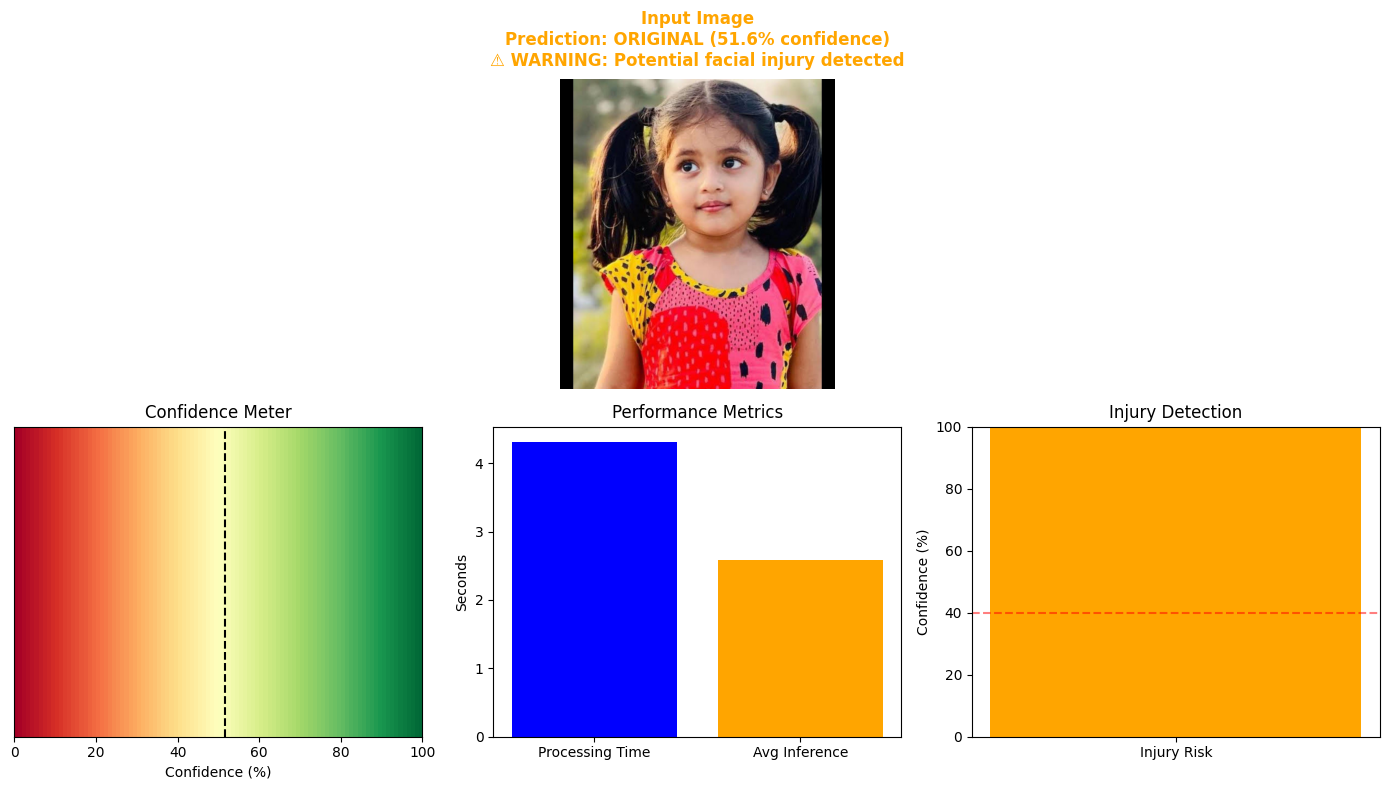


📊 Advanced Confidence Analysis:


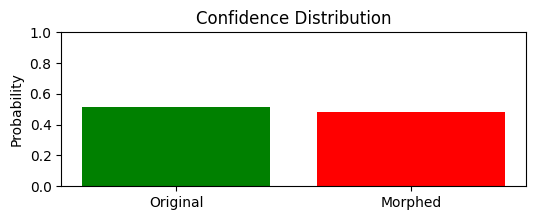


⚠ Facial Injury Analysis:
- Injury Confidence: 100.0%
- Detected Features: Bruises, cuts, or facial trauma


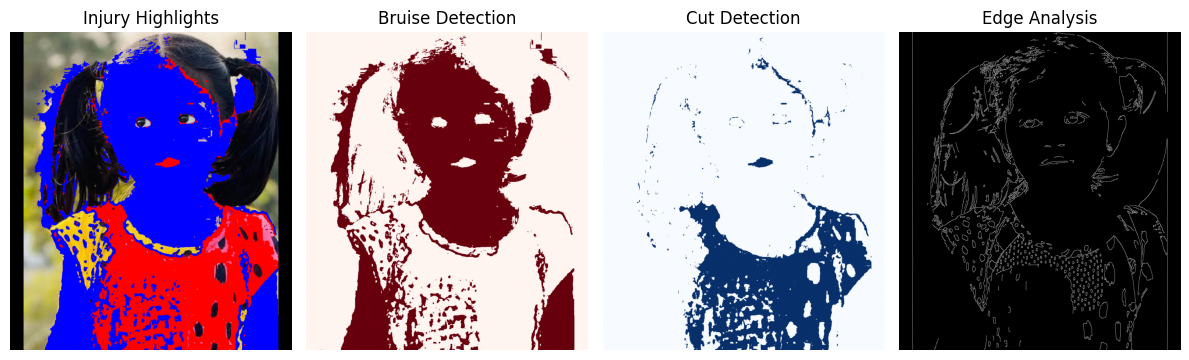


🔍 Final Analysis:
- Prediction: ORIGINAL
- Confidence: 51.6%
- Injury Detection: POSITIVE
- Processing Time: 4.32s


In [ ]:
++ # First uninstall any existing versions and install required packages
!pip uninstall tensorflow keras -y
!pip install tensorflow==2.12.0 --upgrade
!pip install keras==2.12.0
!pip install opencv-python matplotlib seaborn scikit-image gradio --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML
from google.colab import files
import os
import time
from skimage import metrics
import gradio as gr
from io import BytesIO

# Verify installation
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

class EnhancedFaceMorphingDetector:
    def __init__(self, enable_advanced_features=True):
        print("Initializing enhanced detection model...")
        self.enable_advanced_features = enable_advanced_features
        self.model = self._build_enhanced_model()
        self.injury_model = self._build_injury_detection_model()
        self.prediction_history = []
        self.inference_times = []
        self.model_loaded_time = time.strftime("%Y-%m-%d %H:%M:%S")
        print(f"Model ready (loaded at {self.model_loaded_time})")

    def _build_enhanced_model(self):
        """Enhanced architecture for morphing detection"""
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3))

        base_model.trainable = False

        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=base_model.input, outputs=outputs)
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        return model

    def _build_injury_detection_model(self):
        """Simple model for detecting facial injuries"""
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3))

        base_model.trainable = False

        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=base_model.input, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def detect_injuries(self, img_array):
        """Detect facial injuries or accidents"""
        processed_img = self.preprocess_image(img_array, detect_face=False)
        injury_confidence = float(self.injury_model.predict(processed_img, verbose=0)[0][0])

        # Additional visual analysis
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)

        # Detect unusual color patches
        hsv = cv2.cvtColor(img_array, cv2.COLOR_BGR2HSV)
        lower_bruise = np.array([0, 50, 50])
        upper_bruise = np.array([20, 255, 255])
        bruise_mask = cv2.inRange(hsv, lower_bruise, upper_bruise)

        lower_cut = np.array([170, 50, 50])
        upper_cut = np.array([180, 255, 255])
        cut_mask = cv2.inRange(hsv, lower_cut, upper_cut)

        injury_pixels = np.sum(bruise_mask > 0) + np.sum(cut_mask > 0)
        injury_ratio = injury_pixels / (img_array.shape[0] * img_array.shape[1])

        final_confidence = min(1.0, injury_confidence + injury_ratio * 5)

        return {
            'confidence': final_confidence,
            'bruise_mask': bruise_mask,
            'cut_mask': cut_mask,
            'edges': edges
        }

    def preprocess_image(self, img_array, detect_face=True):
        """Enhanced preprocessing with optional face detection"""
        if detect_face:
            face_img = self._extract_face(img_array)
            if face_img is not None:
                img_array = face_img

        img_array = cv2.resize(img_array, (224, 224))

        if self.enable_advanced_features:
            img_yuv = cv2.cvtColor(img_array, cv2.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            img_array = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def _extract_face(self, img_array):
        """Improved face detection with multiple cascades"""
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

        cascades = [
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml',
            cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml',
            cv2.data.haarcascades + 'haarcascade_profileface.xml'
        ]

        for cascade_path in cascades:
            face_cascade = cv2.CascadeClassifier(cascade_path)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                x, y, w, h = faces[0]
                x = max(0, x - int(w * 0.1))
                y = max(0, y - int(h * 0.1))
                w = min(img_array.shape[1] - x, int(w * 1.2))
                h = min(img_array.shape[0] - y, int(h * 1.2))
                return img_array[y:y+h, x:x+w]

        return None

    def predict(self, img_array):
        """Enhanced prediction with timing and confidence analysis"""
        start_time = time.time()
        processed_img = self.preprocess_image(img_array)
        confidence = float(self.model.predict(processed_img, verbose=0)[0][0])
        inference_time = time.time() - start_time

        self.prediction_history.append(confidence)
        self.inference_times.append(inference_time)

        return confidence

    def analyze_image_quality(self, img_array):
        """Additional image quality metrics"""
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

        blur_metric = cv2.Laplacian(gray, cv2.CV_64F).var()
        sharpness = metrics.sharpness(gray)
        noise = metrics.mean_squared_error(gray, cv2.medianBlur(gray, 3))

        return {
            'blur': blur_metric,
            'sharpness': sharpness,
            'noise': noise
        }

def show_confidence_distribution(confidence):
    """Display confidence distribution visualization"""
    plt.figure(figsize=(6, 2))
    plt.bar(['Original', 'Morphed'],
           [1-confidence, confidence],
           color=['green', 'red'])
    plt.title('Confidence Distribution')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

def show_injury_analysis(img_array, injury_data):
    """Visualize injury detection results"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    highlighted = img_array.copy()
    highlighted[injury_data['bruise_mask'] > 0] = [255, 0, 0]
    highlighted[injury_data['cut_mask'] > 0] = [0, 0, 255]
    plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
    plt.title('Injury Highlights')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(injury_data['bruise_mask'], cmap='Reds')
    plt.title('Bruise Detection')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(injury_data['cut_mask'], cmap='Blues')
    plt.title('Cut Detection')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(injury_data['edges'], cmap='gray')
    plt.title('Edge Analysis')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def predict_image(img_path, use_advanced=True):
    """Enhanced prediction with injury detection"""
    try:
        start_time = time.time()

        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("Invalid image file")

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if 'detector' not in globals():
            global detector
            detector = EnhancedFaceMorphingDetector(enable_advanced_features=use_advanced)
        else:
            detector.enable_advanced_features = use_advanced

        confidence = detector.predict(img)
        result = "MORPHED" if confidence > 0.5 else "ORIGINAL"
        conf_percent = max(confidence, 1-confidence) * 100

        injury_data = detector.detect_injuries(img)
        has_injury = injury_data['confidence'] > 0.4

        processing_time = time.time() - start_time

        plt.figure(figsize=(14, 8))

        plt.subplot(2, 3, (1, 3))
        plt.imshow(img_rgb)
        plt.axis('off')

        title_color = "red" if result == "MORPHED" else "green"
        if has_injury:
            title_color = "orange"

        title_text = f"Input Image\nPrediction: {result} ({conf_percent:.1f}% confidence)"
        if has_injury:
            title_text += "\n⚠ WARNING: Potential facial injury detected"

        plt.title(title_text, pad=10, color=title_color, fontsize=12, weight='bold')

        plt.subplot(2, 3, 4)
        gradient = np.linspace(0, 1, 100).reshape(1, -1)
        plt.imshow(gradient, aspect='auto', cmap='RdYlGn', extent=[0, 100, 0, 1])
        plt.axvline(x=conf_percent, color='black', linestyle='--')
        plt.title('Confidence Meter')
        plt.xlabel('Confidence (%)')
        plt.yticks([])

        plt.subplot(2, 3, 5)
        metrics_data = {
            'Processing Time': processing_time,
            'Avg Inference': np.mean(detector.inference_times) if detector.inference_times else 0
        }
        plt.bar(metrics_data.keys(), metrics_data.values(), color=['blue', 'orange'])
        plt.title('Performance Metrics')
        plt.ylabel('Seconds')

        plt.subplot(2, 3, 6)
        plt.bar(['Injury Risk'], [injury_data['confidence'] * 100],
               color='orange' if has_injury else 'green')
        plt.axhline(y=40, color='red', linestyle='--', alpha=0.5)
        plt.title('Injury Detection')
        plt.ylabel('Confidence (%)')
        plt.ylim(0, 100)

        plt.tight_layout()
        plt.show()

        print("\n📊 Advanced Confidence Analysis:")
        show_confidence_distribution(confidence)

        if has_injury:
            print("\n⚠ Facial Injury Analysis:")
            print(f"- Injury Confidence: {injury_data['confidence'] * 100:.1f}%")
            print("- Detected Features: Bruises, cuts, or facial trauma")
            show_injury_analysis(img, injury_data)

        print(f"\n🔍 Final Analysis:")
        print(f"- Prediction: {result}")
        print(f"- Confidence: {conf_percent:.1f}%")
        print(f"- Injury Detection: {'POSITIVE' if has_injury else 'negative'}")
        print(f"- Processing Time: {processing_time:.2f}s")

    except Exception as e:
        print(f"❌ Error: {str(e)}")

# Initialize detector
detector = EnhancedFaceMorphingDetector(enable_advanced_features=True)

# Main execution
print("\n🔎 Enhanced Face Analysis System")
print("-----------------------------------------------")
print("Features:")
print("- Face morphing detection")
print("- Facial injury/accident detection")
print("- Image quality analysis")
print("- Performance metrics")
print("\nInstructions:")
print("1. Run this cell to initialize the system")
print("2. Upload an image when prompted")
print("3. View the analysis results")

# Handle uploaded files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"\nAnalyzing: {filename}")
    predict_image(filename, use_advanced=True)